# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import scipy.stats as stats
import pylab

In [88]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [89]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [90]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [91]:
#Set up data summary

# aggregate values
r = np.sum(data.call)
n = len(data)
p = r/n

#split data by race
w = data[data.race=='w']
b = data[data.race=='b']

#set up call data from df based on race
# white-sounding names
w_r = np.sum(w.call)
w_n = len(w)
w_p = (w_r / w_n)

# black-sounding names
b_r = np.sum(b.call)
b_n = len(b)
b_p = (b_r / b_n)

data1 = {'Callback': np.array([w_r, b_r, r]).astype(int),
        'No Callback': np.array([w_n - w_r, b_n - b_r, n - r]).astype(int),
        'Total': np.array([w_n, b_n, n]).astype(int),
        'Callback Rate': np.array(['{:.2%}'.format(w_r/w_n), '{:.2%}'.format(b_r/b_n), '{:.2%}'.format(r/n)])}

tbl1 = pd.DataFrame(data1, columns = ['Callback', 'No Callback', 'Total', 'Callback Rate'], 
                   index = ['White-sounding names', 'Black-sounding names', 'Aggregate'])
tbl1

,Callback,No Callback,Total,Callback Rate
White-sounding names,235,2200,2435,9.65%
Black-sounding names,157,2278,2435,6.45%
Aggregate,392,4478,4870,8.05%


### 1) What test is appropriate for this problem? Does CLT apply?

Z-test is appropriate since we are comparing observed difference between two proportions to the null. 

CLT applies because this case meets the following requirements:
    1. Randomness
    2. Normal (np [successes] >= 10 and n(1-p) [failures] >= 10)
    3. Independent without replacment (n <= 10% population where our population is the entire US job market)
    
### 2) What are the null and alternate hypotheses

#### Null Hypothesis:
The probabilty of callback success is the same for both white-sounding and black-sounding names (p1 = p2).

#### Alternative Hypothesis:
The probabilty of callback success is not the same for both white-sounding and black-sounding names (p1 != p2).

### 3) Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

In [98]:
# Your solution to Q3 here

def ztest_two_sample(r1, n1, r2, n2, one_sided=False):
    """Returns the z-statistic and p-value for a 2-sample Z-test of proportions"""
    p1 = r1/n1
    p2 = r2/n2
    
    p = (r1+r2)/(n1+n2)
    se = np.sqrt(p*(1-p)*(1/n1+1/n2))
    
    z = (p1-p2)/se
    p = 1-stats.norm.cdf(abs(z))
    p *= 2-one_sided
    return z, p

# 95% confidence interval
prop_diff = w_p - b_p
print('Observed difference in proportions: \t {}\n'.format(prop_diff))

z_crit = 1.96
p_hat1 = w_p*(1-w_p)/w_n
p_hat2 =  b_p*(1-b_p)/b_n
ci_high = prop_diff + z_crit*(np.sqrt(p_hat1 + p_hat2))
ci_low = prop_diff - z_crit*(np.sqrt(p_hat1 + p_hat2))

z_stat, p_val = ztest_proportions_two_samples(w_r, w_n, b_r, b_n)
print('z-stat: \t {}\np-value: \t {}'.format(z_stat, p_val))

print('95% conf int: \t {} - {}'.format(ci_low, ci_high))
moe = (ci_high - ci_low)/2
print('Margin of err: \t +/-{} '.format(moe))

Observed difference in proportions: 	 0.032032854209445585

z-stat: 	 4.108412152434346
p-value: 	 3.983886837577444e-05
95% conf int: 	 0.016777447859559147 - 0.047288260559332024
Margin of err: 	 +/-0.015255406349886438 


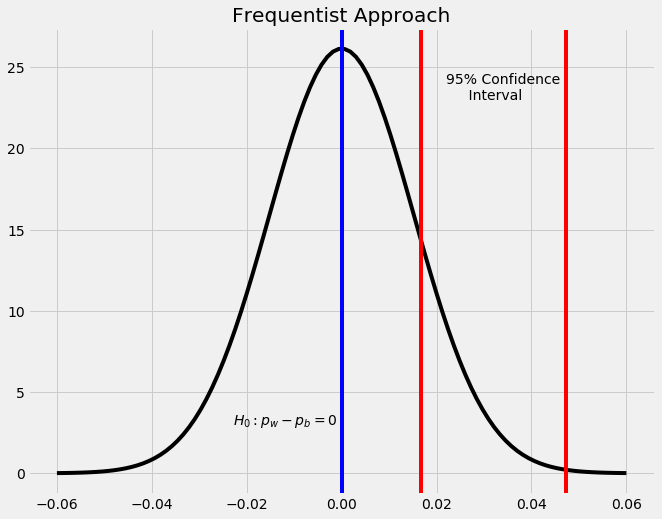

In [101]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (10, 8)

# Graph the Frequentist results


plt.plot(x, pdf, 'k-')
plt.figsize = (10, 8)

_ = plt.axvline(ci_high, color='red')
_ = plt.axvline(ci_low, color='red')
_ = plt.axvline(0, color='blue')
_ = plt.text(-0.023, 3, '$H_0: p_w - p_b = 0$')
_ = plt.text(0.022, 23, '95% Confidence \n     Interval')
_ = plt.title('Frequentist Approach');

### Bootstrap

In [100]:
#Bootstrap 
# Construct arrays of data: white-sounding names, black-sounding names
all_callbacks = np.array([True] * int(r) + [False] * int(n-r))

size = 10000

bs_reps_diff = np.empty(size)

for i in range(size):
    w_bs_replicates = np.sum(np.random.choice(all_callbacks, size=w_n))
    b_bs_replicates = np.sum(np.random.choice(all_callbacks, size=b_n))
    
    bs_reps_diff[i] = (w_bs_replicates - b_bs_replicates)/b_n
    
bs_p_value = np.sum(bs_reps_diff >= prop_diff) / len(bs_reps_diff)

bs_ci = np.percentile(bs_reps_diff, [2.5, 97.5])
bs_mean_diff = np.mean(bs_reps_diff)

print('obs diff: {}\n'.format(prop_diff))
print('BOOTSTRAP RESULTS\np-value: {}\n95% conf. int.: {}'.format(bs_p_value, bs_ci))

obs diff: 0.032032854209445585

BOOTSTRAP RESULTS
p-value: 0.0
95% conf. int.: [-0.01519507  0.01478439]


### 4) Write a story describing the statistical significance in the context of the original problem.

Based on the dataset and analysis we can clearly see that callback proportion for resumes with white-sounding names is significantly higher than the proportion of callbacks for resumes with black-sounding names.

### 5) Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

Based on this analysis as well as the analysis completed by the reseaerchers we can see that there is a clear advantage for white-sounding names to receive callbacks. According to the researchers resumes between white-sounding names and black-sounding names were identical, but higher quality black-sounding names did not receive significantly more callbacks.

If callbacks were not based on race/name then you could analyze the quality of each resume to determine trends for callback failure/success.